In [4]:
%matplotlib inline 

import requests 
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 
import datetime as dt # module for manipulating dates and times
import numpy.linalg as lin # module for performing linear algebra operations
from __future__ import division
import matplotlib
import holidays
import datetime

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [6]:
hourly_data = pd.DataFrame()
raw_watt_2019 = pd.read_csv(f'pv_profiles/sim_pv_profiles_watt/pv_4/pv_profile_id=30_2019_watt.csv')
raw_watt_2020 = pd.read_csv(f'pv_profiles/sim_pv_profiles_watt/pv_4/pv_profile_id=30_2020_watt.csv')
raw_weather_2019 = pd.read_csv(f'weather_data/house_4/weather_id=30_2019.csv', comment='#')
raw_weather_2020 = pd.read_csv(f'weather_data/house_4/weather_id=30_2019.csv', comment='#')
hourly_data['interval'] = raw_watt_2019['interval'].append(raw_watt_2020['interval'])
hourly_data['Power (W)'] = raw_watt_2019['Power (W)'].append(raw_watt_2020['Power (W)'])

index = pd.to_datetime(hourly_data['interval'])
data = hourly_data['Power (W)'].values
series = pd.Series(data=data, index=index)
series = series.resample('1H').sum()
hourly_data = series.to_frame()
hourly_data.rename(columns={0: "Power (W)"}, inplace=True)
hourly_data.reset_index(inplace=True)
temperature = raw_weather_2019['temperature'].append(raw_weather_2020['temperature'].head(744)).values
radiation = raw_weather_2019['radiation_surface'].append(raw_weather_2020['radiation_surface'].head(744)).values
cloud_cover = raw_weather_2019['cloud_cover'].append(raw_weather_2020['cloud_cover'].head(744)).values
hourly_data['temperature'] = temperature
hourly_data['radiation_surface'] = radiation
hourly_data['cloud_cover'] = cloud_cover
hourly_data['month'] = hourly_data['interval'].dt.month
hourly_data['hour_day'] = hourly_data['interval'].dt.hour
hourly_data['available'] = np.zeros(len(hourly_data))
hourly_data.loc[hourly_data['Power (W)'] > 0.0, 'available'] = 1.0
hourly_data.to_csv('testing.csv', index=False)
hourly_data

interval  Power (W)  temperature  radiation_surface  \
0    2019-01-01 00:00:00        0.0        6.516                0.0   
1    2019-01-01 01:00:00        0.0        6.918                0.0   
2    2019-01-01 02:00:00        0.0        7.013                0.0   
3    2019-01-01 03:00:00        0.0        6.709                0.0   
4    2019-01-01 04:00:00        0.0        6.280                0.0   
...                  ...        ...          ...                ...   
9499 2020-01-31 19:00:00        0.0       -1.957                0.0   
9500 2020-01-31 20:00:00        0.0       -2.052                0.0   
9501 2020-01-31 21:00:00        0.0       -2.179                0.0   
9502 2020-01-31 22:00:00        0.0       -2.522                0.0   
9503 2020-01-31 23:00:00        0.0       -3.161                0.0   

      cloud_cover  month  hour_day  available  
0           0.985      1         0        0.0  
1           0.987      1         1        0.0  
2           0.980      1         2        0.0  
3           0.965      1         3        0.0  
4           0.970      1         4        0.0  
...           ...    ...       ...        ...  
9499        0.726      1        19        0.0  
9500        0.856      1        20        0.0  
9501        0.804      1        21        0.0  
9502        0.588      1        22        0.0  
9503        0.190      1        23        0.0  

[9504 rows x 8 columns]

In [7]:
data = pd.read_csv('testing.csv')
# Split into X and y
X = data[['Power (W)','temperature', 'radiation_surface', 'cloud_cover', 'month', 'hour_day', 'available']].values # input
y = data[['Power (W)']].values # only predict energy consumption
# Ensure all data is float
#values = values.astype('float32')
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

window = 1 # or lag, input of how many previous data points used to predict 
#train_length = 28032 # 80% of 2019
total_length = 9504 # 2019 & Jan 2020
test_end = 8760 # 2019

def slice_data(data, fr, to, name):
    result = data[fr:to,:]
    # Check shape
    print(name + ": start at " + str(fr) + " - shape: " + str(result.shape))
    return result

# Adjust y (y starts [window] after X)
n_features = X.shape[1]
trainX = slice_data(X, 0, test_end, 'x') # 0 to 28032
trainy = slice_data(y, window, (test_end+window), 'y') # 1 to 28033, depending on the window
# Reshape in 3D input format
trainX = np.reshape(trainX, (trainX.shape[0], window, n_features))
print(trainX.shape, trainy.shape)

x: start at 0 - shape: (8760, 7)
y: start at 1 - shape: (8760, 1)
(8760, 1, 7) (8760, 1)


Epoch 1/50
7/7 [==============================] - 3s 78ms/step - loss: 0.1010 - val_loss: 0.0180
Epoch 2/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0872 - val_loss: 0.0178
Epoch 3/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0771 - val_loss: 0.0192
Epoch 4/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0687 - val_loss: 0.0217
Epoch 5/50
7/7 [==============================] - 0s 19ms/step - loss: 0.0619 - val_loss: 0.0243
Epoch 6/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0564 - val_loss: 0.0261
Epoch 7/50
7/7 [==============================] - 0s 22ms/step - loss: 0.0517 - val_loss: 0.0266
Epoch 8/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0473 - val_loss: 0.0257
Epoch 9/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0430 - val_loss: 0.0238
Epoch 10/50
7/7 [==============================] - 0s 18ms/step - loss: 0.0388 - val_loss: 0.0212
Epoch 11/50
7/7 [============

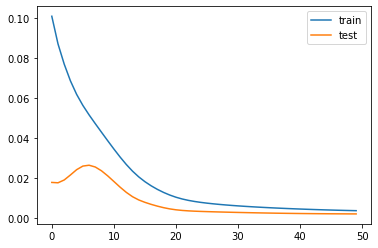

Test MSE: 8777639.090
Test RMSE: 2962.708


In [8]:
" Simple model """
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
model.compile(loss="mse", optimizer="rmsprop")
#model.summary()

# fit network
history = model.fit(trainX, trainy, epochs=50, batch_size=1024, validation_split=0.2, verbose=1, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.layers import concatenate

# Predict values for Jan 2020
# Prepare input 
forecastX = X[test_end-window:total_length-window]
# Prepare real energy consumption
real_y = y[test_end:]
# Reshape to required format and predict
forecastX = np.reshape(forecastX, (forecastX.shape[0], window, n_features))
forecasted_y = model.predict(forecastX)
# invert scaling
inv_yhat = scaler.inverse_transform(forecasted_y)
inv_y = scaler.inverse_transform(real_y)
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)

Epoch 1/50
7/7 [==============================] - 8s 293ms/step - loss: 0.1135 - val_loss: 0.0216
Epoch 2/50
7/7 [==============================] - 1s 110ms/step - loss: 0.1097 - val_loss: 0.0205
Epoch 3/50
7/7 [==============================] - 1s 79ms/step - loss: 0.1048 - val_loss: 0.0193
Epoch 4/50
7/7 [==============================] - 1s 82ms/step - loss: 0.0976 - val_loss: 0.0181
Epoch 5/50
7/7 [==============================] - 0s 68ms/step - loss: 0.0864 - val_loss: 0.0184
Epoch 6/50
7/7 [==============================] - 0s 51ms/step - loss: 0.0711 - val_loss: 0.0264
Epoch 7/50
7/7 [==============================] - 0s 55ms/step - loss: 0.0586 - val_loss: 0.0451
Epoch 8/50
7/7 [==============================] - 0s 55ms/step - loss: 0.0539 - val_loss: 0.0456
Epoch 9/50
7/7 [==============================] - 0s 52ms/step - loss: 0.0470 - val_loss: 0.0316
Epoch 10/50
7/7 [==============================] - 0s 63ms/step - loss: 0.0397 - val_loss: 0.0225
Epoch 11/50
7/7 [==========

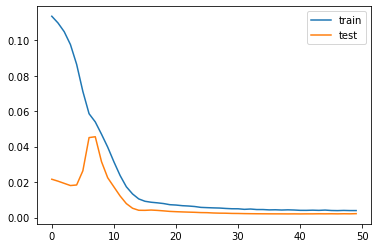

Test MSE: 7693190.255
Test RMSE: 2773.660


In [9]:
""" Complex model2 """
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

dropout = 0.2
model2 = Sequential()
model2.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model2.add(Dropout(dropout))
model2.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
model2.add(Dropout(dropout))
model2.add(Dense(16, activation="relu", kernel_initializer="uniform"))
model2.add(Dense(1, activation="relu", kernel_initializer="uniform"))
model2.compile(loss="mse", optimizer="adam")
#model2.summary()

# fit network
history2 = model2.fit(trainX, trainy, epochs=50, batch_size=1024, validation_split=0.2, verbose=1, shuffle=False)

# plot history
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show()

from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.layers import concatenate

# Predict values for Jan 2020
# Prepare input 
forecastX2 = X[test_end-window:total_length-window]
# Prepare real energy consumption
real_y2 = y[test_end:]
# Reshape to required format and predict
forecastX2 = np.reshape(forecastX2, (forecastX2.shape[0], window, n_features))
forecasted_y2 = model2.predict(forecastX2)
# invert scaling
inv_yhat2 = scaler.inverse_transform(forecasted_y2)
inv_y2 = scaler.inverse_transform(real_y2)
# calculate MSE & RMSE
mse2 = mean_squared_error(inv_y2, inv_yhat2)
rmse2 = sqrt(mean_squared_error(inv_y2, inv_yhat2))
print('Test MSE: %.3f' % mse2)
print('Test RMSE: %.3f' % rmse2)

In [1]:
del model, model2

NameError: name 'model' is not defined

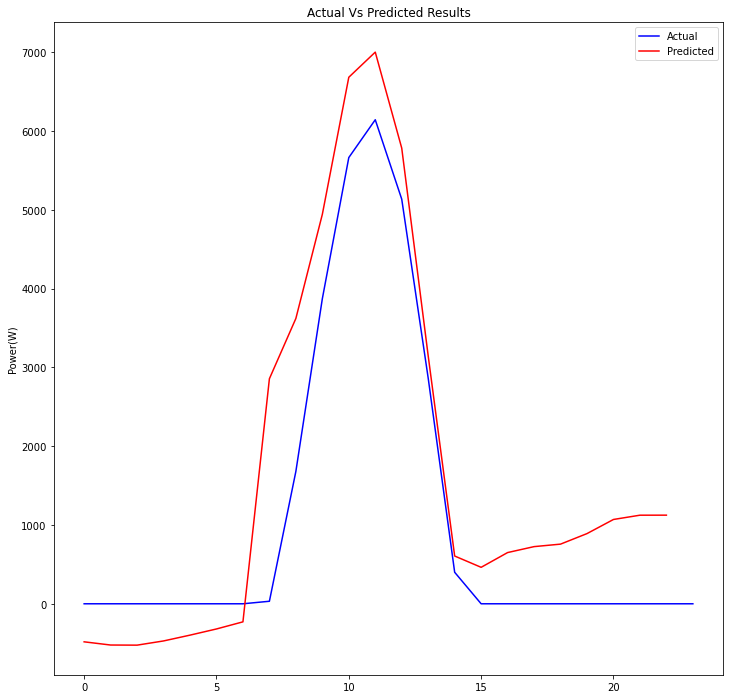

In [97]:
steps = 24
plt.figure(figsize=(12, 12))
plt.plot(inv_y[:steps], label='Actual', color="blue")
plt.plot(inv_yhat[1:steps], label='Predicted', color="red")
plt.ylabel("Power(W)")
plt.title("Actual Vs Predicted Results")
plt.legend()
plt.show()

In [98]:
df = pd.DataFrame()
df['interval'] = (pd.DataFrame(columns=['INTERVAL'],
                  index=pd.date_range('2020-01-01T00:00:00Z', '2020-01-31T23:45:00Z',
                                      freq='1H'))
       #.between_time('0:00','23:59')
       .index.strftime('%Y-%m-%dT%H:%M')
       .tolist()
        )
df['Actual'] = inv_y
df['Power (W)'] = inv_yhat
df.head(96)
#df.to_csv('predict.csv', index=False)

interval  Actual    Power (W)
0   2020-01-01T00:00     0.0  -851.791992
1   2020-01-01T01:00     0.0  -482.893982
2   2020-01-01T02:00     0.0  -523.553711
3   2020-01-01T03:00     0.0  -525.097961
4   2020-01-01T04:00     0.0  -471.733032
..               ...     ...          ...
91  2020-01-04T19:00     0.0  1057.328125
92  2020-01-04T20:00     0.0  1099.752319
93  2020-01-04T21:00     0.0  1123.637817
94  2020-01-04T22:00     0.0  1137.571899
95  2020-01-04T23:00     0.0  1141.160278

[96 rows x 3 columns]